# S01_Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from shutil import copyfile
import zipfile

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/data.zip"

We have 7 csv files in the zip, their filenames are:
*  **tbl_addresses**: contains info on address corresponding to a customer account
*  **tbl_customer_accounts**: contains info on the loyalty account associated to the customers
* **tbl_customer_reviews**: contains the reviews made by the customers
* **tbl_customers**: contains info on the customers
*  **tbl_labelled_reviews**: contains a set of review texts with the sentiment labels assigned (ground-truth)
* **tbl_orders**: contains all the orders made by the customers, i.e. all the products purchased or refunded by the
customers
* **tbl_products**: contains the info on the products



# CSV File: "tbl_addresses"


*   address_id: Identify address (key)
*   postal_code: Postal code of the address
*   district: Province/district of the address
*   region: Region of the address

Concerning the handling of missing values, it was decided to convert NaN values to 0 in order to perform certain operations on the numerical values

In [ ]:
# Extract file: tbl_addresses
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_addresses.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

FileNotFoundError: ignored

In [ ]:
# File path of the extracted 'tbl_addresses.csv' filE
csv_file_path = "tbl_addresses.csv"

# Read CSV file, treating empty cells as NaN and replace them with 0
tbl_addresses = pd.read_csv(csv_file_path, na_values=[""]).fillna(0)

# Convert the "postal_code" column to nullable integers (Int64)
tbl_addresses["postal_code"] = pd.to_numeric(tbl_addresses["postal_code"]).astype(pd.Int64Dtype())

tbl_addresses

In [ ]:
# We have a look on the rows in which the columns have zero value
pd.set_option('display.max_rows',None)
tbl_addresses[(tbl_addresses['postal_code'] >=0) & (tbl_addresses['postal_code'] <=1)].sort_values(by='postal_code')


In [ ]:
tbl_addresses.info()
tbl_addresses.shape

## Drop Duplicates

In [ ]:
#are there duplicates?
tbl_addresses.duplicated().sum()

Despite the significant number of duplicates, we decided to remove them, as we had to merge several datasets and these rows did not add significant information

In [ ]:
tbl_addresses = tbl_addresses.drop_duplicates()

In [ ]:
# Count occurrences of value 0 for each column
zero_counts = (tbl_addresses == 0).sum()

print(zero_counts)

We aim to determine the region and district values based on the provided postal codes. To assist us in this task, we utilize the Italian municipal code list (https://dait.interno.gov.it/territorio-e-autonomie-locali/sut/elenco_codici_comuni.php) alongside the Italian Post Office site (https://www.poste.it/cap.html) and another external resource (https://en.youbianku.com/Italy) to gather relevant information about postal codes and their corresponding regions and districts.

Firstly we focus on the column district by creating a new column named "clean_district". Using the sources mentioned above, we assign the correct district values to this new column. For postal codes referring to districts outside of Italy, such as San Marino, Vatican City and Ticino, we have chosen to assign "Estero"  to the "region" column. This approach simplifies visualization and categorization of those specific cases.



In [ ]:
# Use the assign method to create a new DataFrame with the "clean_district" column
tbl_addresses = tbl_addresses.assign(clean_district=tbl_addresses["district"])

In [ ]:
# We rietrieve the district and the region by looking at the postal code
ranges = [

     (10,199),    # "RM": "LAZIO"
     (120,120),   # "VATICANO": "ESTERO"
     (1010,1039), # "VT":"LAZIO"
     (1100,1100), # "VT":"LAZIO"
     (2010,2049), # "RI":"LAZIO"
     (2100,2100), # "RI":"LAZIO"
     (3010,3049), #"FR": "LAZIO"
     (3100,3100), #"FR": "LAZIO"
     (4010,4029), # "LT": "LAZIO"
     (4100,4100), # "LT": "LAZIO"
     (5010,5039), # "TR": "UMBRIA"
     (5100,5100), # "TR": "UMBRIA"
     (6121,6135), # "PG": "UMBRIA"
     (6010,6100), # "PG": "UMBRIA" The postal code of Perugia reaches up to 6089 but there are 15 lines with postal code = 6100. We believe this is a typing error on the client's side, as the district refers to Perugia.
     (7010,7019), # "SS": "SARDEGNA"
     (7030,7049), # "SS": "SARDEGNA"
     (7100,7100), # "SS": "SARDEGNA"
     (7020,7029), #"OT": "SARDEGNA"
     (8020,8020), #"OT": "SARDEGNA"
     (8100,8100), #"NU": "SARDEGNA"
     (8010,8039), #"NU": "SARDEGNA"
     (8040,8049), #"OG": "SARDEGNA"
     (9121,9134), #"CA":"SARDEGNA"
     (9010,9049), #"CA":"SARDEGNA"
     (8030,8030), #"CA":"SARDEGNA"
     (9170,9170), #"OR":"SARDEGNA"
     (9070,9099), #"OR":"SARDEGNA"
     (8013,8013), #"OR":"SARDEGNA"
     (8030,8030), #"OR":"SARDEGNA"
     (9010,9017), #"CI":"SARDEGNA"
     (9020,9041),  #"MD":"SARDEGNA"
     (10010,10100), #"TO":"PIEMONTE" The postal code of Turin reaches up to 10099 but there are more than 40 lines with postal code = 10100. We believe this is a typing error on the client's side, as the district refers to Turin.
     (10121,10156), #"TO":"PIEMONTE"
    (18025,18025), #"CN":"PIEMONTE"
    (22010,22079), #"CO":"LOMBARDIA"
    (23100,23100), #"SO":"LOMBARDIA"
    (23801,23899), #"LC":"LOMBARDIA"
     (28010,28079), #"NO":"PIEMONTE"
    (28801,28899), #"VB":"PIEMONTE"
     (30121,30176),# "VE":"VENETO"
     (30010,30039), # "VE":"VENETO"
     (31010,31059), # "TV":"VENETO"
    (36010,36078), #"VI": "VENETO"
     (37121,37142),# "VR":"VENETO"
    (37010,37069),# "VR":"VENETO"
    (40010,40069),# "BO":	"EMILIA ROMAGNA"
    (41010, 41059), # "MO": "EMILIA ROMAGNA"
    (42010, 42049), #"RE":"EMILIA ROMAGNA"
    (44010,44049), #"FE":"EMILIA ROMAGNA"
    (47010,47043), # "FC":	"EMILIA ROMAGNA"
    (47814, 47855), #"RN":"EMILIA ROMAGNA"
    (47890,47890), # "SAN MARINO": "ESTERO",
    (47891,47899), #"SAN MARINO": "ESTERO",
    (50010,50068), #"FI":	"TOSCANA"
    (51010,51039), #"PT":	"TOSCANA"
    (52010,52048), #"AR":	"TOSCANA"
    (54010,54038), #"MS":	"TOSCANA"
    (55010,55064), #"LU":	"TOSCANA"
    (56010,56048),  #"PI":	"TOSCANA"
   (57014,57039), #"LI":	"TOSCANA"
   (63010, 63049), # "AP":"MARCHE"
   (59011,59026),  #"PO":	"TOSCANA"
  (66010,66054), # "CH":	"ABRUZZO"
(65010,65029),# "PE":	"ABRUZZO"
(64010,64049),# "TE":	"ABRUZZO"
(70121,70131),# "BA":	"PUGLIA"
(70010,70059), #"BA":	"PUGLIA"
(72010,72029), #"BR":	"PUGLIA"
(74010, 74028),#"TA":	"PUGLIA"
 (80121,80147), #"NA": "CAMPANIA"
 (80010,80079), #"NA": "CAMPANIA"
(87010,87076),# "CS":"CALABRIA"
(90121,90151),# "PA": "SICILIA"
(88020,88070),# "CZ":"CALABRIA"
(95121,95131),# "CT": "SICILIA"
(20121,20162), # "MI": "LOMBARDIA"

(40121,40141), # "BO": "EMILIA ROMAGNA"
(47814,47855), # "RN": "EMILIA ROMAGNA"

]

# Create a list of district values
districts = ["RM", "VATICANO", "VT", "VT", "RI", "RI", "FR", "FR","LT", "LT", "TR", "TR", "PG", "PG", "SS", "SS", "SS", "OT","OT", "NU", "NU","OG", "CA","CA","CA","OR","OR","OR","OR", "CI","MD","TO","TO", "CN","CO","SO","LC","NO","VB","VE", "VE", "TV","VI","VR","VR","BO", "MO","RE", "FE","FC","RN","SAN MARINO","SAN MARINO",
             "FI", "PT", "AR", "MS", "LU", "PI", "LI", "AP", "PO", "CH", "PE", "TE", "BA", "BA", "BR", "TA", "NA", "NA","CS","PA", "CZ", "CT", "MI","BO","RN"
 ]

# Use numpy.where to update the "district" column based on the ranges
for index, range_val in enumerate(ranges):
    condition = (tbl_addresses["postal_code"] >= range_val[0]) & (tbl_addresses["postal_code"] <= range_val[1])
    tbl_addresses["clean_district"] = np.where(condition, districts[index], tbl_addresses["clean_district"])

# Create a dictionary to map regions based on the district value
region_dict = {
    "RM": "LAZIO",
    "VATICANO": "VATICANO",
    "VT":"LAZIO",
    "RI":"LAZIO",
    "FR": "LAZIO",
    "LT": "LAZIO",
    "TR": "UMBRIA",
    "PG": "UMBRIA",
    "SS": "SARDEGNA",
    "OT": "SARDEGNA",
    "NU": "SARDEGNA",
    "OG": "SARDEGNA",
    "CA":"SARDEGNA",
    "OR":"SARDEGNA",
    "CI":"SARDEGNA",
    "MD":"SARDEGNA",
    "TO":"PIEMONTE",
    "CN":"PIEMONTE",
    "CO":"LOMBARDIA",
    "SO":"LOMBARDIA",
    "LC":"LOMBARDIA",
    "NO":"PIEMONTE",
    "VB":"PIEMONTE",
    "VE":"VENETO",
    "TV":"VENETO",
    "VI": "VENETO",
    "VR":"VENETO",
    "BO":"EMILIA ROMAGNA",
    "MO": "EMILIA ROMAGNA",
   "RE":"EMILIA ROMAGNA",
    "FE":"EMILIA ROMAGNA",
    "FC":	"EMILIA ROMAGNA",
    "RN":"EMILIA ROMAGNA",
   "SAN MARINO": "ESTERO",
    "FI":	"TOSCANA",
    "PT":	"TOSCANA",
    "AR":	"TOSCANA",
    "MS":	"TOSCANA",
    "LU":	"TOSCANA",
    "PI":	"TOSCANA",
   "LI":	"TOSCANA",
    "AP":"MARCHE",
   "PO":	"TOSCANA",
   "CH":	"ABRUZZO",
   "PE":	"ABRUZZO",
  "TE":	"ABRUZZO",
  "BA":	"PUGLIA",
  "BR":	"PUGLIA",
  "TA":	"PUGLIA",
  "NA": "CAMPANIA",
  "CS":"CALABRIA",
  "PA": "SICILIA",
  "CZ":"CALABRIA",
  "CT": "SICILIA",
  "MI": "LOMBARDIA",
  "RN": "EMILIA ROMAGNA"
}

# Create a temporary "region" column using map function
tbl_addresses["temp_region"] = tbl_addresses["clean_district"].map(region_dict)

# Combine the temporary "region" column with the existing one and fill missing values
tbl_addresses["region"] = tbl_addresses["temp_region"].fillna(tbl_addresses["region"])

# Drop the temporary "region" column
tbl_addresses.drop(columns=["temp_region"], inplace=True)


In [ ]:
zero_counts = (tbl_addresses == 0).sum()
print(zero_counts)

By examining the "address_id" column, we arrange the districts related to "ESTERO" value in "region" column, and we ensure that all region names are standardized in the same format.

In [ ]:
#6xxx - Region Central Switzerland (Innerschweiz), Tessin  https://en.wikipedia.org/wiki/Postal_codes_in_Switzerland_and_Liechtenstein

# List of addresses that should have "clean_district" set to "TICINO"
addresses_to_ticino = [719037, 299783, 311087, 380395, 290752, 292570, 311087, 131519, 399573, 238413, 885731, 746579, 679768, 480470, 606749, 381758]

# Use the loc method to set "clean_district" to "TICINO" and "Region" to "Estero" based on the conditions
tbl_addresses.loc[tbl_addresses["address_id"].isin(addresses_to_ticino), "clean_district"] = "TICINO"
tbl_addresses.loc[tbl_addresses["address_id"].isin(addresses_to_ticino), "region"] = "ESTERO"

# Set "clean_district" to "STRASBURGO" and "Region" to "Estero" for address 637107
tbl_addresses.loc[tbl_addresses["address_id"] == 637107, "clean_district"] = "STRASBURGO"
tbl_addresses.loc[tbl_addresses["address_id"] == 637107, "region"] = "ESTERO"

# Set "clean_district" to "MALTA" and "Region" to "Estero" for address 170301
tbl_addresses.loc[tbl_addresses["address_id"] == 170301, "clean_district"] = "MALTA"
tbl_addresses.loc[tbl_addresses["address_id"] == 170301, "region"] = "ESTERO"

# Set "clean_district" to "BADEN-WUDENBERG" and "Region" to "Estero" for address 324482
tbl_addresses.loc[tbl_addresses["address_id"] == 324482, "clean_district"] = "BADEN-WUDENBERG"
tbl_addresses.loc[tbl_addresses["address_id"] == 324482, "region"] = "ESTERO"

# Set "clean_district" to "BUCAREST" and "Region" to "Estero" for address 651937
tbl_addresses.loc[tbl_addresses["address_id"] == 651937, "clean_district"] = "BUCAREST"
tbl_addresses.loc[tbl_addresses["address_id"] == 651937, "region"] = "ESTERO"


# Set "clean_district" to "VATICANO" and "Region" to "Estero" for address 507620
tbl_addresses.loc[tbl_addresses["address_id"] == 507620	, "clean_district"] = "VATICANO"
tbl_addresses.loc[tbl_addresses["address_id"] == 507620	, "region"] = "ESTERO"


In [ ]:
# All districts with region = 0 and invalid postcode are set to zero (Nan value)
tbl_addresses.loc[tbl_addresses["address_id"].isin([460124, 66480, 67130, 679232, 76051, 591013,10171,84179,361045, 116702, 558055, 774181, 723942, 450038, 405188, 84179,89074, 47813, 716597, 36176, 64199, 472575, 401642,114610		]), "clean_district"] = 0

In [ ]:
pd.set_option('display.max_rows',None)
tbl_addresses[tbl_addresses['region'] ==0]

In [ ]:
# Count occurrences of value 0 for each column
zero_counts = (tbl_addresses == 0).sum()

# Count total number of rows in the DataFrame
total_rows = tbl_addresses.shape[0]

# Calculate percentage of occurrences of 0 for each column
percent_zero_counts = (zero_counts / total_rows) * 100

# Combine the total counts and percentage into a DataFrame
missing_data = pd.concat([zero_counts, percent_zero_counts], axis=1, keys=['Total', 'Percent'])
missing_data

# CSV File: "tbl_customers"



*  **customer_id**: Identify the
customer
(key)
*  **address_id**: Identify address
(foreign key)
*  **birthdate**: Date of birth of the
customer
*  **gender**: Customer gender,
if provided by the
customer
* **job_type**: Customer job, if
provided by the
customer
* **email_provider**: Provider of the
email account
provided by the
customer
* **flag_phone_provided**: True/False if the
customer provide
the phone number
* **flag_privacy**: True/False if the
customer accepts
privacy terms





In [ ]:
# Extract file: tbl_addresses
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_customers.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

We generated the 'age' column by calculating the difference between the current year (2023) and the customers' date of birth. Then, we categorized the ages into different groups using bins, creating the 'age_group' column.   Furthermore, in the binary column 'category_provider_mail', customers with personal email addresses starting with 'personal_mail_provider_' were assigned a value of 1, while others were assigned a value of 0.

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customers.csv"
tbl_customers = pd.read_csv(csv_file_path)

# Replace Nan with a default value, such as 0
tbl_customers['flag_phone_provided'] = tbl_customers['flag_phone_provided'].fillna(0).astype(bool)
#we convert flag_phone in int type
tbl_customers['flag_phone_provided'] = tbl_customers['flag_phone_provided'].astype(int)
# we convert birthdate as date type
tbl_customers['birthdate'] = pd.to_datetime(tbl_customers['birthdate'], format='%Y-%m-%d')
#Create a new column 'genders' based on the 'gender' column
tbl_customers["genders"] = tbl_customers["gender"].map({"M": 1, "F": 0})

tbl_customers

In [ ]:
tbl_customers.info()
tbl_customers.shape

In [ ]:
# From a first glance, it appears that there are missing values
tbl_customers.isnull().sum()

In [ ]:
dates = []
for i in tbl_customers["birthdate"]:
    i = i.date()
    dates.append(i)
#Datebirth of the oldest and youngest recorded customer

print("The datebirth of the youngest customer in the dataset:",max(dates))
print("The datebirth of the oldest customer in the dataset:",min(dates))

In [ ]:
# Create an age variable by substracting the datebirth from the current year (2023)
tbl_customers['Age'] = (pd.Timestamp('2023-01-01') - tbl_customers['birthdate']).dt.days // 365
# Mean and median are quite close, at first glance we might indicate that the age variable is well distributed among the observations

In [ ]:
tbl_customers["job_type"].unique()

In [ ]:
# Create a new column `age_group`
age_group = pd.cut(tbl_customers['Age'], #pd.cut function is used to bin the 'Age' values into different age groups
      bins = [tbl_customers['Age'].min(), 26, 36, 46, 56, 66, 76, 86, tbl_customers['Age'].max()],
      labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '> 86']) #These are the intermediate values that define the upper boundaries of each age group.
tbl_customers['age_group'] = age_group

In [ ]:
tbl_customers['email_provider'].value_counts()

In [ ]:
# The regular expression r'personal_mail_provider_\d+' is used to find and replace occurrences of values matching the pattern with 'personal_mail_provider'
tbl_customers['email_provider'] = tbl_customers['email_provider'].str.replace(r'personal_mail_provider_\d+', 'personal_mail_provider')


In [ ]:
tbl_customers.head(40)

# CSV File: "tbl_customer_accounts"




*  **customer_id**: Identify the customer
(foreign key)
*   **account_id**: Identify the customer’s
loyalty account
(key)
* **favorite_store**: Identify the customer’s
favourite store (1-49)
* **Loyalty_type**: Identify which type of
loyalty account the
customer has: ['premium', 'business premium', 'standard', 'business standard']
* **loyalty_status**: Identify the status of the
loyalty account
*  **activation_date**: Identify the activation
date of the account






In [ ]:
# Extract file: tbl_customer_accounts
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_customer_accounts.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

In this section, we convert the categorical loyalty column into a numeric range. We also count subscription days by taking the date of the last subscription as a reference

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customer_accounts.csv"
tbl_customer_accounts = pd.read_csv(csv_file_path)

In [ ]:
duplicate_count = tbl_customer_accounts.duplicated().sum()
duplicate_count

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customer_accounts.csv"
tbl_customer_accounts = pd.read_csv(csv_file_path)

# Define the list of plan types in the order of hierarchy (lowest to highest)
plan_hierarchy = ['standard', 'business standard', 'premium', 'business premium']

# Convert the 'loyalty_type' column to a categorical data type with the specified hierarchy
tbl_customer_accounts['loyalty_type'] = pd.Categorical(tbl_customer_accounts['loyalty_type'], categories=plan_hierarchy, ordered=True)

# Get the underlying integer codes for the 'loyalty_type' column
tbl_customer_accounts['loyalty_code'] = tbl_customer_accounts['loyalty_type'].cat.codes

In [ ]:
# Convert activation_date as date type and after to days
tbl_customer_accounts['activation_date'] = pd.to_datetime(tbl_customer_accounts['activation_date'], format='%Y-%m-%d')

# To determine the current timestamp, I used the last subscription of a customer. With the subtraction, I compute the duration of the subscription
tbl_customer_accounts['activation_date_days'] = (pd.Timestamp('2023-05-11') - tbl_customer_accounts['activation_date']).dt.days

# max(2023-05-11) and min(2022-01-01) are respectively 495 days and 0

In [ ]:
tbl_customer_accounts.info()
tbl_customer_accounts.shape

In [ ]:
tbl_customer_accounts.head(40)

In [ ]:
# From a first glance, it appears that there are no missing values
tbl_customer_accounts.isnull().sum()

In [ ]:
result= tbl_customer_accounts.groupby(['account_id']).agg(count=('account_id', 'size')).reset_index().sort_values(by='count', ascending=False)
result.groupby('count').count()

it is noteceable  that most customers have kept the same loyalty accounts, with 406 of customers have changed plans twice and one person has changed plan 3 times

In [ ]:
results= tbl_customer_accounts.groupby(['customer_id']).agg(count=('customer_id', 'size')).reset_index().sort_values(by='count', ascending=False)
results.groupby('count').count()

According to the last query, it can be observed that 295 customer_ids had 2 linked account_id, moreover 1 customer had 4 connected accounts. Some of them also had the same subscription activation date.

#CSV File: "tbl_customer_reviews"




*  **review_id**: Identify the review(key)
*  **customer_id**: Identify the customer who made the review (foreign key)
*  **review_text**: Review full text






In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_customer_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_customer_reviews.csv"
tbl_customer_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_customer_reviews.info()
tbl_customer_reviews.shape

In [ ]:
# From a first glance, it appears that there are no missing values
tbl_customer_reviews.isnull().sum()

#CSV File: "tbl_labelled_reviews"




*   **labelled_review_id**:Identify the review (key)

*   **review_text**:Review full text

*  **sentiment_label**:Sentiment assigned to the review







In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_labelled_reviews.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_labelled_reviews.csv"
tbl_labelled_reviews = pd.read_csv(csv_file_path)

In [ ]:
tbl_labelled_reviews .info()
tbl_labelled_reviews .shape

In [ ]:
# From a first glance, it appears that there are no missing values
tbl_labelled_reviews.isnull().sum()

In [ ]:
tbl_labelled_reviews

In [ ]:
pd.set_option('display.max_colwidth', None)

# Filter the DataFrame to get the row with labelled_reviews_index == 462740 and display the 'review_text'
row_review_text = tbl_labelled_reviews[tbl_labelled_reviews['labelled_reviews_index'] == 140945	]['review_text'].values
# Print the review_text value
print(row_review_text[0])

# CSV File: "tbl_products"



*   **product_id**: Identify the product (key)
*   **product_class**: Identify the department corresponding to the
product



In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_products.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_products.csv"
tbl_products = pd.read_csv(csv_file_path)

In [ ]:
tbl_products.duplicated().sum()

In [ ]:
tbl_products.info()
tbl_products.shape

In [ ]:
# From a first glance, it appears that there are no missing values
tbl_products.isnull().sum()

# CSV File: "tbl_orders"



*   **order_id**:identify the transaction (all the products purchased or refund within the
same transaction have the same id)

*  **customer_id**:identify client
(foreign key)

*   **store_id**:identify reference store
(foreign key)

*   **product_id**:identify the purchased or refund item
(foreign key)
*   **direction**: Identify if the product within the order has been
purchased (1) or refunded (-1)


*  **gross_price**: [Euro] gross price = net price – price_reduction
(negative if the product has been refunded)


*  **price_reduction**: [in Euro] price reduction applied
(negative if the product has been refunded)


*  **purchase_datetime**: date and time of the purchase



In [ ]:
# Extract file: tbl_customer_review
t0 = time()
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_orders.csv')
print("File extraction completed in %0.3f seconds" % (time() - t0))

In [ ]:
# File path of the extracted 'tbl_customers.csv' file
csv_file_path = "tbl_orders.csv"
tbl_orders = pd.read_csv(csv_file_path, parse_dates=["purchase_datetime"])

# Split date and time components
tbl_orders['purchase_date'] = tbl_orders['purchase_datetime'].dt.date
tbl_orders['purchase_time'] = tbl_orders['purchase_datetime'].dt.time


tbl_orders['Week'] = tbl_orders['purchase_datetime'].dt.hour



In [ ]:
pd.set_option('display.max_rows',None)
tbl_orders[(tbl_orders['direction'] == 1) & (tbl_orders['gross_price'] < 0)   & (tbl_orders['price_reduction'] == 0.0)]



In [ ]:
tbl_orders.info()
tbl_orders.shape

## Drop Duplicates

In [ ]:
tbl_orders.duplicated().sum()

In [ ]:
tbl_orders[tbl_orders.duplicated()]


In [ ]:
tbl_orders = tbl_orders.drop_duplicates()

In [ ]:
# Extract month, day, and week of the year, hour
#tbl_orders['Month'] = tbl_orders['purchase_datetime'].dt.month
tbl_orders['Day'] = tbl_orders['purchase_datetime'].dt.day
tbl_orders['Week'] = tbl_orders['purchase_datetime'].dt.isocalendar().week

In [ ]:
# Corrected list of days of the week
days_of_week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

# Map the day of the week based on the 'purchase_date'
tbl_orders['day_of_week'] = tbl_orders['purchase_datetime'].dt.weekday.map(dict(enumerate(days_of_week)))

In [ ]:
tbl_orders.head(10)

## Handling gross_price and price_reduction with opposite sign

The 'net price' is determined by adding 'gross_price' and 'price_reduction' exclusively for products with both positive 'gross_price' and 'price_reduction. In all other instances, NaN  values were assigned. This approach ensures the consistency of subsequent computations for columns such as 'percentage discount','customer_total_spent', and 'total purchases'.

In [ ]:
# By excluding the refunded purchases, we compute the percentage discount applied for each product purchased and we set 'net_price' and 'pct_discount' to NaN for rows with price reduction and gross price with opposite sign
tbl_orders['net_price'] = tbl_orders['gross_price'] + tbl_orders['price_reduction'].mask((tbl_orders['price_reduction'] * tbl_orders['gross_price']) < 0)
# We set values in the 'net_price' column to NaN where 'net_price' is less than 0
tbl_orders['net_price'] = tbl_orders['net_price'].mask(tbl_orders['net_price'] < 0)
#Calculate the 'pct_discount(%)' column by dividing 'price_reduction' by 'net_price', multiplying by 100 to express it as a percentage.
tbl_orders['pct_discount(%)'] = ((tbl_orders['price_reduction'] / tbl_orders['net_price']) * 100).round(2)


#104
#tbl_orders = tbl_orders.loc[~((tbl_orders['direction'] < 0) & (tbl_orders['gross_price'] > 0))]
#tbl_orders = tbl_orders.loc[~((tbl_orders['direction'] > 0) & (tbl_orders['gross_price'] < 0))]

We also used the same method to calculate customer total spent and customer total purchases

In [ ]:
# Calculate prezzo_netto for each order
tbl_orders['gross_price_revised']=round(tbl_orders['net_price'] - (tbl_orders['net_price'] * tbl_orders['pct_discount(%)'] / 100),2)
# Calcola il prezzo netto per ogni ordine
df = tbl_orders.copy()

df = df.groupby('customer_id').agg(
    customer_total_spent=('gross_price_revised', 'sum'),  # Retain 'customer_total_spent'
    customer_total_purchases=('order_id', 'nunique')
).reset_index()


# Merge the result back into the original tbl_orders DataFrame
tbl_orders = pd.merge(tbl_orders, df, on='customer_id', how='left')

In [ ]:
df

In [ ]:
tbl_orders.loc[tbl_orders['customer_id'] ==50]

In [ ]:
# Convert 'purchase_date' to datetime format
tbl_orders['purchase_date'] = pd.to_datetime(tbl_orders['purchase_date'])
# Create a boolean mask for rows where 'gross_price_revised' is not null
mask = tbl_orders['gross_price_revised'].notnull()
# Create a new column 'last_purchase_date' with the maximum 'purchase_date' for each customer, considering the mask
tbl_orders['last_purchase_date'] = tbl_orders[mask].groupby('customer_id')['purchase_date'].transform('max')

# Calculate the days from the last purchase for each row using pd.Timestamp('2023-04-30')
tbl_orders['days_from_last_purchase'] = (pd.Timestamp('2023-04-30') - tbl_orders['last_purchase_date']).dt.days

In [ ]:
# Filter the DataFrame to keep only the rows with the 'last_purchase_date'
filter = tbl_orders[tbl_orders['purchase_date'] == tbl_orders['last_purchase_date']]

# Calculate the total spending and total number of products purchased for each customer on their last purchase date
customer_summary = filter.groupby(['customer_id', 'last_purchase_date']).agg(
     last_day_tot_amount = ('gross_price_revised', 'sum'),
    last_day_num_products= ('product_id', 'count')
).reset_index()

tbl_orders= pd.merge(tbl_orders, customer_summary, on=['customer_id','last_purchase_date'], how='left')

In [ ]:
tbl_orders[tbl_orders['customer_id'] == 929562]

In [ ]:
tbl_orders.info()
tbl_orders.shape

In [ ]:
tbl_orders.isnull().sum()

# Merging, dropping and cleaning

In [ ]:
pip install sweetviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 84.2 MB/s eta 0:00:00


In [ ]:
import sweetviz as sv

In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/file aggiornati.zip"

In [ ]:
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('tbl_addresses.csv')
    zip.extract('tbl_customers.csv')
    zip.extract('tbl_customer_accounts.csv')
    zip.extract('tbl_customer_reviews.csv')
    zip.extract('tbl_products.csv')
    zip.extract('tbl_orders.csv')

tbl_addresses = pd.read_csv("tbl_addresses.csv")
tbl_customers = pd.read_csv("tbl_customers.csv")
tbl_customer_accounts = pd.read_csv("tbl_customer_accounts.csv")
tbl_customer_reviews = pd.read_csv("tbl_customer_reviews.csv")
tbl_products = pd.read_csv("tbl_products.csv")
tbl_orders = pd.read_csv("tbl_orders.csv")

## Merging

In [ ]:
dataset = pd.merge(tbl_orders, tbl_customers, on='customer_id', how='left' ) #1.039.865
dataset = pd.merge(dataset, tbl_addresses, on='address_id', how='left' ) #1.650.451
dataset = pd.merge(dataset,  tbl_customer_accounts, on='customer_id', how='left' ) #1.654.841
dataset = pd.merge(dataset,  tbl_products, on='product_id', how='left' ) #1.654.841

dataset['flag_privacy'] = dataset['flag_privacy'].astype(int)

<ipython-input-60-9f52afc7faef>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  dataset = pd.merge(dataset,  tbl_customer_accounts, on='customer_id', how='left' ) #1.654.841


In [ ]:
total_number_purchases = dataset[dataset['direction'] == 1].groupby('customer_id')['order_id'].nunique()
dataset['tot_number_purchases'] = dataset['customer_id'].map(total_number_purchases)

In [ ]:
dataset[['order_id','customer_id','product_id','purchase_date', 'purchase_time','tot_number_purchases']][dataset['customer_id']== 30]

,order_id,customer_id,product_id,purchase_date,purchase_time,tot_number_purchases
38,88b9dc81f8b601c78824ac62311a7eb4,30,35649740,2022-06-11,18:41:54,2
39,2685d6e34e5f26eea7bd6143fa7ed3e4,30,35075523,2022-07-23,07:06:38,2
40,2685d6e34e5f26eea7bd6143fa7ed3e4,30,35765324,2022-07-23,07:06:38,2
41,2685d6e34e5f26eea7bd6143fa7ed3e4,30,48500403,2022-07-23,07:06:38,2


In [ ]:
dataset.rename(columns={'customer_total_spent': 'tot_amount_spent'}, inplace=True)

print("Shape:",dataset.shape)

Shape: (919829, 50)


In [ ]:
dataset = dataset.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'])

## First profiling

In [ ]:
report = sv.analyze(dataset)
report.show_html('report_1.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report_1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
# First of all, we proceed dropping job_type due to the really high amount of missing values (94.6%)
dataset = dataset.drop(columns=['job_type'])

## Low Variance

In [ ]:
variances = dataset.var()
variances

<ipython-input-67-265895907a01>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variances = dataset.var()


customer_id                 5.894569e+10
store_id                    2.010067e+02
product_id                  9.022793e+13
direction                   1.297048e-01
gross_price                 8.017784e+03
price_reduction             1.541885e+02
Week                        2.402877e+02
Day                         7.833715e+01
net_price                   8.822938e+03
pct_discount(%)             2.889870e+01
gross_price_revised         7.224002e+03
tot_amount_spent            5.561714e+05
customer_total_purchases    5.932279e+02
days_from_last_purchase     7.865467e+03
last_day_tot_amount         3.574806e+04
last_day_num_products       2.137806e+01
address_id                  5.680589e+10
flag_phone_provided         9.444536e-02
flag_privacy                1.196530e-01
genders                     2.470868e-01
Age                         1.221360e+02
postal_code                 7.889649e+08
account_id                  5.325908e+10
favorite_store              2.294204e+02
loyatlty_status 

In [ ]:
threshold = 0.01 # we choose that as threshold value, obviosly we could evaluate how we will perform with other thresholds
# in other cases, it would also drop the 'phone' flag, but we drop it later anyway, so it doesn't make a difference
low_variance_features = variances[variances < threshold].index.tolist()
low_variance_features

['loyatlty_status']

## Matrici di correlazione

In [ ]:
a=dataset[dataset['age_group'].isna()]
a[['age_group','Age']]

,age_group,Age
783175,NaN,19
783176,NaN,19
783177,NaN,19
783178,NaN,19
783179,NaN,19
783180,NaN,19
783181,NaN,19
783182,NaN,19
783183,NaN,19
783184,NaN,19


In [ ]:
dataset['age_group'].fillna('18-25', inplace=True)

In [ ]:
numero_nan = dataset['age_group'].isna().sum()
numero_nan

0

In [ ]:
categorie_ord = {'18-25': 1, '26-35': 2, '36-45': 3, '46-55': 4, '56-65': 5, '66-75': 6, '76-85': 7, '> 86': 8}

# Create a new column with ordinal values
dataset['age_group_ordinal'] = dataset['age_group'].replace(categorie_ord)

In [ ]:
# Obtain the correlation coefficients that each numerical variable in the dataset has with three variables representing the three aspects of RFM

correlation_matrix_recency = dataset.corrwith(dataset['days_from_last_purchase'])
correlation_df_recency = pd.DataFrame(correlation_matrix_recency, columns=['correlation with recency'])

correlation_matrix_frequency = dataset.corrwith(dataset['tot_number_purchases'])
correlation_df_frequency = pd.DataFrame(correlation_matrix_frequency, columns=['correlation with frequency'])

correlation_matrix_monetary = dataset.corrwith(dataset['tot_amount_spent'])
correlation_df_monetary = pd.DataFrame(correlation_matrix_monetary, columns=['correlation with monetary'])

correlation_df = pd.concat([correlation_df_recency, correlation_df_frequency, correlation_df_monetary], axis=1)
correlation_df

<ipython-input-73-8c3cd9616232>:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_recency = dataset.corrwith(dataset['days_from_last_purchase'])
<ipython-input-73-8c3cd9616232>:6: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_frequency = dataset.corrwith(dataset['tot_number_purchases'])
<ipython-input-73-8c3cd9616232>:9: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_monetary = dataset.corrwith(dataset['tot_amo

,correlation with recency,correlation with frequency,correlation with monetary
customer_id,-0.189036,-0.135279,0.017931
store_id,0.013620,-0.020830,0.001290
product_id,-0.042048,-0.018460,-0.016754
direction,-0.001055,-0.004171,-0.111874
gross_price,0.032703,-0.025062,0.163292
price_reduction,0.019349,-0.008219,0.130418
Week,0.217834,0.035477,0.025494
Day,-0.030221,0.000072,-0.004782
net_price,0.032033,-0.026108,0.237556
pct_discount(%),0.031702,0.008293,0.191456


In [ ]:
# Age
correlation_age = correlation_df.loc[['Age','age_group_ordinal']]
correlation_age

,correlation with recency,correlation with frequency,correlation with monetary
Age,-0.399672,0.318745,0.090705
age_group_ordinal,-0.392839,0.309863,0.087067


## ANOVA e t-Student

In [ ]:
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

since in this analysis we require that the three RFM reference variables do not have missing values, we check in the report. tot_number_purchases and tot_amount_spent do not have missing values, but days_from_last_purchase does. We need to handle them.

In [ ]:
missing_last_purchase_days = dataset[dataset['days_from_last_purchase'].isna()]
missing_last_purchase_days

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,purchase_date,purchase_time,...,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,loyalty_code,activation_date_days,product_class,tot_number_purchases,age_group_ordinal
12,7927c5116d8aae47d86b75f67ac94a6f,23,49,33794292,-1,-1.99,0.0,2022-11-17 10:49:29,2022-11-17,10:49:29,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
13,7927c5116d8aae47d86b75f67ac94a6f,23,49,33795776,-1,-5.10,0.0,2022-11-17 10:49:29,2022-11-17,10:49:29,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
71,f74d58077490151356324b25f6f29052,48,49,33933655,-1,-43.92,0.0,2022-12-29 17:56:21,2022-12-29,17:56:21,...,456894,49,premium,1,2022-08-08,2,276,3,15,6
74,ceb935c410873ca3213826fa0b393976,48,49,31047464,-1,-3.92,0.0,2022-12-29 19:10:38,2022-12-29,19:10:38,...,456894,49,premium,1,2022-08-08,2,276,3,15,6
75,ceb935c410873ca3213826fa0b393976,48,49,33883955,-1,-113.00,0.0,2022-12-29 19:10:38,2022-12-29,19:10:38,...,456894,49,premium,1,2022-08-08,2,276,3,15,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919553,6e21ab52559a47b71fd8670608b754d9,926607,39,81269181,-1,-11.52,0.0,2023-04-27 10:12:47,2023-04-27,10:12:47,...,918156,39,standard,1,2023-04-26,0,15,2,2,3
919554,148ecd18f8c783fafd5898f794ea812b,926607,39,81269181,-1,-23.04,0.0,2023-04-27 10:13:09,2023-04-27,10:13:09,...,918156,39,standard,1,2023-04-26,0,15,2,2,3
919597,c8b4e94fdfb6acfa76b5375ca176f8d7,927548,39,32842642,-1,-2.40,0.0,2023-04-27 11:54:14,2023-04-27,11:54:14,...,919315,39,premium,1,2023-04-26,2,15,3,2,3
919598,c8b4e94fdfb6acfa76b5375ca176f8d7,927548,39,32842600,-1,-21.60,0.0,2023-04-27 11:54:14,2023-04-27,11:54:14,...,919315,39,premium,1,2023-04-26,2,15,3,2,3


In [ ]:
# From this code we understand that probably filling the missing values with the customer-associated value, which can be found in other rows of the same table, should be sufficient
a=dataset[dataset['customer_id']==23]
a

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,purchase_date,purchase_time,...,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,loyalty_code,activation_date_days,product_class,tot_number_purchases,age_group_ordinal
0,8fe4346b53d0c781b275a614175804de,23,49,35551922,1,125.40,0.00,2022-10-04 18:28:51,2022-10-04,18:28:51,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
1,8fe4346b53d0c781b275a614175804de,23,49,30344384,1,8.30,0.00,2022-10-04 18:28:51,2022-10-04,18:28:51,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
2,8fe4346b53d0c781b275a614175804de,23,49,33794292,1,1.99,0.00,2022-10-04 18:28:51,2022-10-04,18:28:51,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
3,8fe4346b53d0c781b275a614175804de,23,49,33795776,1,5.10,0.00,2022-10-04 18:28:51,2022-10-04,18:28:51,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
4,8fe4346b53d0c781b275a614175804de,23,49,36235381,1,76.05,0.00,2022-10-04 18:28:51,2022-10-04,18:28:51,...,512658,49,standard,1,2022-09-08,0,245,6,7,3
5,c2ae3673970490406925dcd3f8a4d486,23,49,35002296,1,1.70,0.17,2022-10-31 13:07:42,2022-10-31,13:07:42,...,512658,49,standard,1,2022-09-08,0,245,3,7,3
6,c2ae3673970490406925dcd3f8a4d486,23,49,32157580,1,1.90,0.19,2022-10-31 13:07:42,2022-10-31,13:07:42,...,512658,49,standard,1,2022-09-08,0,245,3,7,3
7,c2ae3673970490406925dcd3f8a4d486,23,49,35930902,1,0.70,0.07,2022-10-31 13:07:42,2022-10-31,13:07:42,...,512658,49,standard,1,2022-09-08,0,245,3,7,3
8,c2ae3673970490406925dcd3f8a4d486,23,49,81268736,1,9.90,0.99,2022-10-31 13:07:42,2022-10-31,13:07:42,...,512658,49,standard,1,2022-09-08,0,245,13,7,3
9,c2ae3673970490406925dcd3f8a4d486,23,49,35930965,1,2.25,0.23,2022-10-31 13:07:42,2022-10-31,13:07:42,...,512658,49,standard,1,2022-09-08,0,245,3,7,3


In [ ]:
# We do so
dataset['last_purchase_date'] = dataset.groupby('customer_id')['last_purchase_date'].fillna(method='ffill')

In [ ]:
# We check if there are still any missing values
still_missing = dataset[dataset['last_purchase_date'].isna()]
still_missing

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,purchase_date,purchase_time,...,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,loyalty_code,activation_date_days,product_class,tot_number_purchases,age_group_ordinal
68820,8ac8138db21f36c4ca1856fdce928775,53815,17,35761670,1,-9.90,0.0,2023-04-05 13:14:08,2023-04-05,13:14:08,...,886954,17,business standard,1,2023-04-05,1,36,7,2,4
171061,f9369e372ff7b40d2064995e920f4181,154824,37,32381916,1,-1.50,0.0,2022-05-27 11:58:26,2022-05-27,11:58:26,...,288682,37,standard,1,2022-05-12,0,364,10,5,4
172169,6faaefd728dd1bf529c0d0c0d117160d,156142,2,35609231,1,-0.55,0.0,2022-07-27 17:59:54,2022-07-27,17:59:54,...,54631,2,standard,1,2022-01-28,0,468,3,3,3
223155,1296cce5f163ee93361de3dc62929cf3,212351,20,33700716,1,-0.20,0.0,2022-05-12 11:51:45,2022-05-12,11:51:45,...,116243,20,standard,1,2022-02-25,0,440,10,1,3
248721,354727bf9da27e86bd2c0b5151a536c9,240596,33,33700716,1,-0.20,0.0,2022-05-05 18:14:21,2022-05-05,18:14:21,...,147601,33,standard,1,2022-03-10,0,427,10,15,3
248780,ebd938cbd497867c06f35d001b52a931,240640,12,34919822,1,-2.90,0.0,2022-05-08 14:54:35,2022-05-08,14:54:35,...,147648,12,standard,1,2022-03-10,0,427,3,1,3
304234,bfee7dd6e5cf8c09980ffdf9fe4221e1,298356,49,32988690,1,-5.45,0.0,2022-05-13 15:22:56,2022-05-13,15:22:56,...,211065,49,premium,1,2022-04-08,2,398,3,5,3
310920,89ff9ad42ab49c44d1ba54edc79352f0,304581,22,33700716,1,-0.20,0.0,2022-06-14 10:36:46,2022-06-14,10:36:46,...,217904,22,standard,1,2022-04-10,0,396,10,3,3
398032,2a54b2453b74eb1410655e52a5243253,378500,30,33120913,1,-2.80,0.0,2022-05-19 13:20:49,2022-05-19,13:20:49,...,300594,10,premium,1,2022-05-18,2,358,9,6,4
406158,d52c7404e681d2f2c7d7db9116acac8a,384209,2,32483780,1,-14.00,0.0,2023-01-19 12:25:29,2023-01-19,12:25:29,...,307186,2,standard,1,2022-05-21,0,355,2,1,4


In [ ]:
a=dataset[dataset['customer_id']==554487]
a['last_purchase_date']

623987           NaN
623988    2022-09-10
623989    2022-09-10
623990    2022-09-10
623991    2022-09-10
Name: last_purchase_date, dtype: object

In [ ]:
# We see that they exist! Well, there are 17 rows; we are not overly concerned, so we drop them
dataset = dataset.dropna(subset=['last_purchase_date'])

In [ ]:
still_missing = dataset[dataset['last_purchase_date'].isna()]
still_missing

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,purchase_date,purchase_time,...,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date,loyalty_code,activation_date_days,product_class,tot_number_purchases,age_group_ordinal


In [ ]:
# We also recalculate 'days_from_last_purchase' so as to fill it
dataset['last_purchase_date'] = pd.to_datetime(dataset['last_purchase_date'])
dataset['days_from_last_purchase'] = (pd.Timestamp('2023-04-30') - dataset['last_purchase_date']).dt.days

In [ ]:
# First of all we evaluate district and clean district
grouped_data_district = dataset.groupby('district')[['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
anova_result_district = f_oneway(*[group for name, group in grouped_data_district])

grouped_data_clean_district = dataset.groupby('clean_district')[['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
anova_result_clean_district = f_oneway(*[group for name, group in grouped_data_clean_district])

print("district: ", anova_result_district, "\nclean district: ", anova_result_clean_district)

district:  F_onewayResult(statistic=array([ 64.25214495, 150.55897386, 122.38659542]), pvalue=array([0., 0., 0.])) 
clean district:  F_onewayResult(statistic=array([ 88.05118086, 197.21598523, 131.62550156]), pvalue=array([0., 0., 0.]))


In [ ]:
# As the results are better for the clean district, we drop the unclean district
dataset = dataset.drop(columns=['district'])

now we evaluate all categorical variables with more than two possible values, applying ANOVA. The higher results will be the best

In [ ]:
grouped_data = dataset.groupby('email_provider')[['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
anova_result_email_provider = f_oneway(*[group for name, group in grouped_data])

In [ ]:
grouped_data = dataset.groupby('day_of_week')[['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
anova_result_day_of_week = f_oneway(*[group for name, group in grouped_data])

In [ ]:
grouped_data = dataset.groupby('loyalty_code')[['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
anova_result_loyalty_code = f_oneway(*[group for name, group in grouped_data])

In [ ]:
print('risultati ANOVA per email provider: ', anova_result_email_provider,
      '\nrisultati ANOVA per day of week: ', anova_result_day_of_week,
      '\nrisultati ANOVA per loyalty code: ', anova_result_loyalty_code)

risultati ANOVA per email provider:  F_onewayResult(statistic=array([16.4105346 , 30.65690027, 65.95959729]), pvalue=array([0., 0., 0.])) 
risultati ANOVA per day of week:  F_onewayResult(statistic=array([ 95.20743607, 109.4626793 , 766.17124075]), pvalue=array([4.04920095e-120, 1.47079634e-138, 0.00000000e+000])) 
risultati ANOVA per loyalty code:  F_onewayResult(statistic=array([ 1863.39383323, 11305.51210307, 49403.64123207]), pvalue=array([0., 0., 0.]))


Given the following situation
*   Variable: loyalty code Highest F statistic: 48275.83028539
*   Variable: day of week F statistic: 755.14548721
*   Variable: email provider F statistic: 72.1273222

we proceed by eliminating email_provider

In [ ]:
dataset = dataset.drop(columns=['email_provider'])

now we evaluate all categorical variables with only two possible values, applying a t-test. I will then decide which ones to eliminate based on the results.

In [ ]:
group_0 = dataset[dataset['flag_phone_provided'] == 0][['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
group_1 = dataset[dataset['flag_phone_provided'] == 1][['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
t_statistic, p_value = ttest_ind(group_0, group_1)
print("Valori delle statistiche t per flag_phone_provided:")
print(t_statistic)
print("\nValori p:")
print(p_value)

Valori delle statistiche t per flag_phone_provided:
[-50.7958192   34.52752501 124.8937115 ]

Valori p:
[0.00000000e+000 4.56275885e-261 0.00000000e+000]


In [ ]:
group_0 = dataset[dataset['genders'] == 0][['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
group_1 = dataset[dataset['genders'] == 1][['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
t_statistic, p_value = ttest_ind(group_0, group_1)
print("Valori delle statistiche t per genders:")
print(t_statistic)
print("\nValori p:")
print(p_value)

Valori delle statistiche t per genders:
[ 161.41872681 -127.74178295  -32.82258452]

Valori p:
[0.00000000e+000 0.00000000e+000 3.84591279e-236]


In [ ]:
group_0 = dataset[dataset['flag_privacy'] == 0][['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
group_1 = dataset[dataset['flag_privacy'] == 1][['days_from_last_purchase', 'tot_number_purchases', 'tot_amount_spent']]
t_statistic, p_value = ttest_ind(group_0, group_1)
print("Valori delle statistiche t per flag_privacy:")
print(t_statistic)
print("\nValori p:")
print(p_value)

Valori delle statistiche t per flag_privacy:
[-196.36943173  150.33590025   49.22903474]

Valori p:
[0. 0. 0.]


In [ ]:
# Based on the comparison of t-statistics values, we drop the two flags
dataset = dataset.drop(columns=['flag_phone_provided','flag_privacy'])

## Duplicates

as already evident from the initial overview, there are no duplicates (they have already been addressed at the level of individual tables)

## Outliers

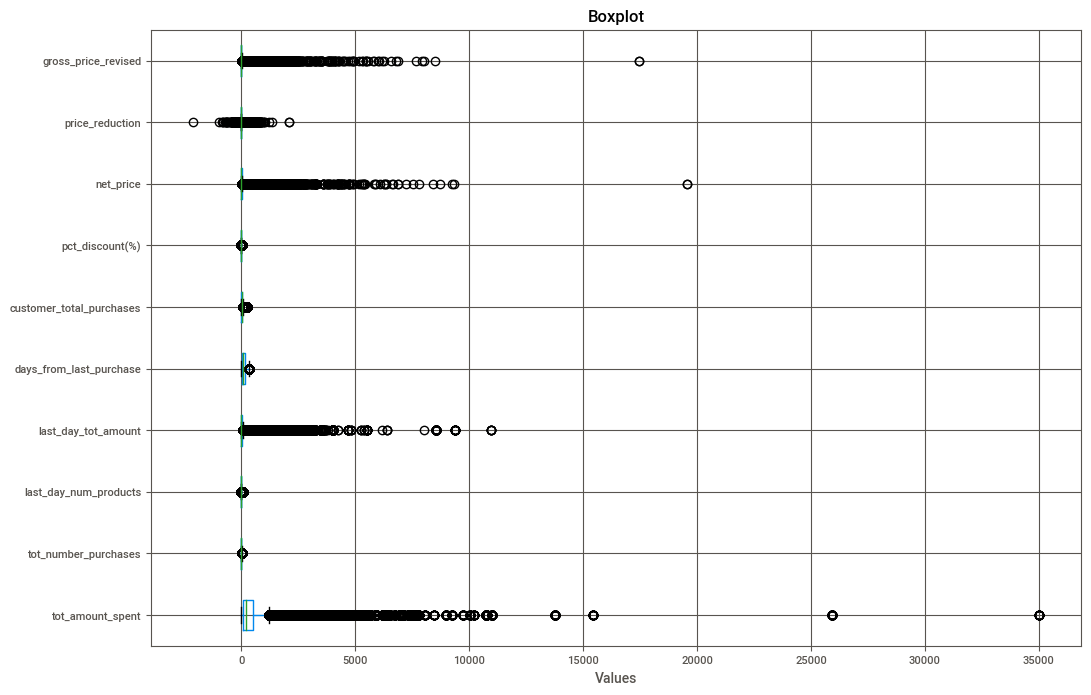

In [ ]:
columns_to_evaluate=['tot_amount_spent','tot_number_purchases','last_day_num_products','last_day_tot_amount','days_from_last_purchase','customer_total_purchases','pct_discount(%)','net_price','price_reduction','gross_price_revised']

plt.figure(figsize=(12, 8))
dataset[columns_to_evaluate].boxplot(vert=False)

plt.title("Boxplot")
plt.xlabel("Values")
plt.show()

we notice that there are 6 columns that seem to have outliers worth removing

In [ ]:
columns_of_interest=['tot_amount_spent','last_day_tot_amount','net_price','price_reduction','gross_price_revised']

price_reduction_sorted = dataset.sort_values(by=['price_reduction'], ascending=False)
print('i più alti:\n',price_reduction_sorted['price_reduction'].head(5),'e i più bassi\n', price_reduction_sorted['price_reduction'].tail(5))

i più alti:
 463055    2096.50
463053    2095.80
783588    1359.93
390098    1203.90
160584    1034.66
Name: price_reduction, dtype: float64 e i più bassi
 576083    -774.00
621817    -792.01
153976    -819.75
880160    -979.30
463054   -2095.80
Name: price_reduction, dtype: float64


In [ ]:
# Define the dictionary of maximum and minimum thresholds for each variable
maximum_thresholds = {
    'tot_amount_spent': 8000,
    'last_day_tot_amount': 3200,
    'net_price': 3750,
    'price_reduction': 2000,
    'gross_price_revised': 3800,
}
minimum_thresholds = {
    'price_reduction': -2000,
    'gross_price_revised': -2000,
}

In [ ]:
# Create a for cycle for all the maximums
for column, threshold in maximum_thresholds.items():
    outliers = dataset[dataset[column] > threshold]
    dataset = dataset.drop(outliers.index)

In [ ]:
# ...and one for the minimums
for column, threshold in minimum_thresholds.items():
    outliers = dataset[dataset[column] < threshold]
    dataset = dataset.drop(outliers.index)

In [ ]:
dataset.shape

(918967, 41)

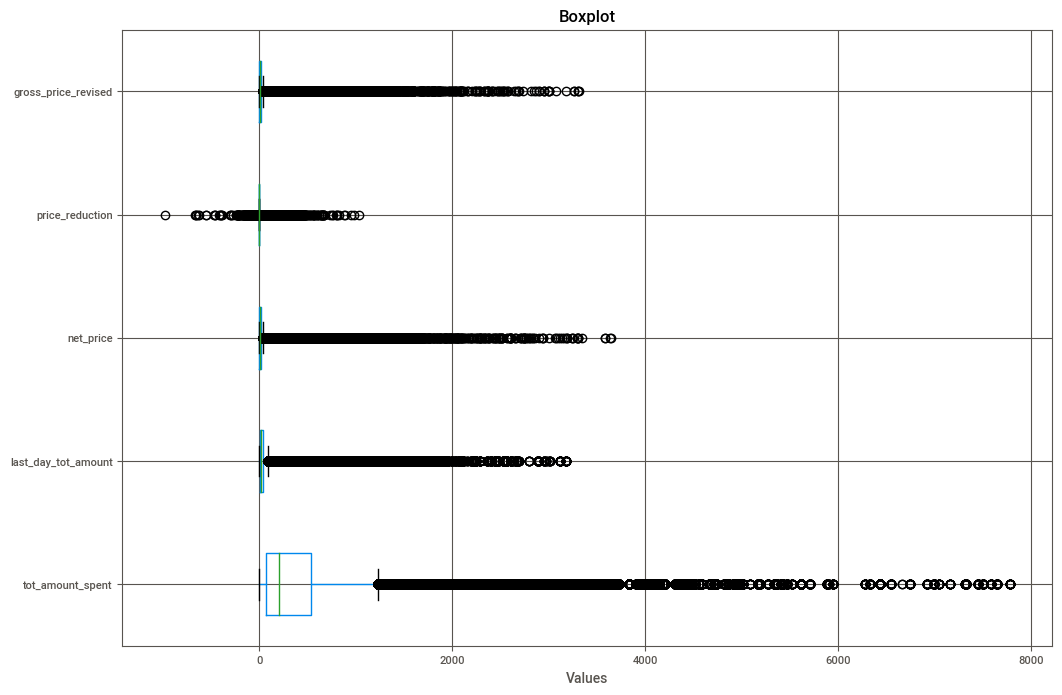

In [ ]:
# Check
plt.figure(figsize=(12, 8))
dataset[columns_of_interest].boxplot(vert=False)

plt.title("Boxplot")
plt.xlabel("Values")
plt.show()

## Second profiling

In [ ]:
report = sv.analyze(dataset)
report.show_html('report_2.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report_2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Export of the dataset
before exporting, we modify columns' order

In [ ]:
dataset.columns

Index(['order_id', 'customer_id', 'store_id', 'product_id', 'direction',
       'gross_price', 'price_reduction', 'purchase_datetime', 'purchase_date',
       'purchase_time', 'Week', 'Day', 'day_of_week', 'net_price',
       'pct_discount(%)', 'gross_price_revised', 'tot_amount_spent',
       'customer_total_purchases', 'last_purchase_date',
       'days_from_last_purchase', 'last_day_tot_amount',
       'last_day_num_products', 'address_id', 'birthdate', 'gender', 'genders',
       'Age', 'age_group', 'postal_code', 'region', 'clean_district',
       'account_id', 'favorite_store', 'loyalty_type', 'loyatlty_status',
       'activation_date', 'loyalty_code', 'activation_date_days',
       'product_class', 'tot_number_purchases', 'age_group_ordinal'],
      dtype='object')

In [ ]:
new_column_order = ['order_id', 'customer_id', 'store_id', 'product_id','product_class','direction','gross_price_revised','price_reduction','net_price','pct_discount(%)',
                    'purchase_date','purchase_time', 'Week', 'Day', 'day_of_week','tot_amount_spent', 'customer_total_purchases','tot_number_purchases',
                    'last_purchase_date', 'days_from_last_purchase', 'last_day_tot_amount','last_day_num_products','address_id', 'genders', 'age_group',
                    'postal_code', 'region', 'clean_district', 'account_id','favorite_store', 'loyalty_code', 'activation_date_days']
dataset = dataset[new_column_order]

In [ ]:
dataset.to_csv('dataset.csv')
!cp dataset.csv "drive/My Drive/marketing analytics"